# Part2. Voice Synthesize with Tacotron2 + WaveGlow
by ** Hyungon Ryu** | Sr. Solution Architect at NVIDIA




```

```

----


  **Content**
- Part1. Voice Synthesis with NVIDIA  WaveGlow Model
- **Part2. Voice Synthesis with NVIDIA Tacotron2 + WaveGlow**


In this jupyter, I'll demonstrate how to synthesdis voice from text to voice with  integrating Tacotron2 and WaveGlow Model.  

after run whole step Part1. Voice Synthesis with NVIDIA WaveGlow Model, 
open this jupyter and reconnect it. you could omit the step1 and download WaveGlow files because the COLAB jupyter would be located in same VM. 


Click **REFRESH** button to update file explorer windows to check previoius work. 

- waveglow directory which clone from git repository
- waveglow_old.pt file exist in `/content` directory.

In [0]:
!ls -alh waveglow_old.pt

ls: cannot access 'waveglow_old.pt': No such file or directory


## Step1.  DevOps

### allocate GPU

At the time of creation of this jupyter notebook I already selected GPU as a preference Accelerator option. Before we get started, let's see if a GPU is allocated.


Select  the **[EDIT]** menu > Select the  **[Notebook Settings]** >  and check the box of ** [ GPU ]** option. 


#### check Tesla K80
Google COLAB provide <a href="https://images.nvidia.com/content/pdf/kepler/Tesla-K80-BoardSpec-07317-001-v05.pdf" target="_blank_"> Tesla K80</a> with 12GB Memory. 
You can see the assigned GPU information with simple command  `nvidia-smi`

In [0]:
!nvidia-smi | grep Tesla

|   0  Tesla K80           On   | 00000000:00:04.0 Off |                    0 |


#### system information and configure
You can see detailed information about the specs for free systems offered by Google COLAB.  In particular, the nvidia-smi tool allows you to adjust the Tesla K80's application clock to its highest application clock rate of 875 Mhz

In [0]:
%%bash
#check the environemnt 
echo "Check H/W"
lscpu | grep 'CPU(s):            '
lscpu | grep GHz
echo "memory" && free -m | cut -c-49 |  head -n 2 
echo "storage" && df -h |  cut -c-60 | head -n 2
df -h |  grep '/dev/sda1'
echo " " && nvidia-smi -L | cut -c-17
echo "confure Max Application Clock for K80 875Mhz"
nvidia-smi -ac 2505,875 && nvidia-smi -pm 1
echo " " &&echo "Check S/W"
cat /etc/*-release | grep PRETTY_NAME
python --version 
nvcc --version | grep  tools

Check H/W
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
memory
              total        used        free      
Mem:          13022         413        4577      
storage
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  9.5G  331G   3% /
/dev/sda1       365G   13G  353G   4% /opt/bin
 
GPU 0: Tesla K80 
confure Max Application Clock for K80 875Mhz
Applications clocks set to "(MEM 2505, SM 875)" for GPU 00000000:00:04.0
All done.
Persistence mode is already Enabled for GPU 00000000:00:04.0.
All done.
 
Check S/W
PRETTY_NAME="Ubuntu 18.04.1 LTS"
Python 3.6.6
Cuda compilation tools, release 9.2, V9.2.148



### clone WaveGlow  Model

**SKIP** if you launch jupyter after finish to run Part1 Voice Synthesis with NVIDIA  WaveGlow Model. This Jupyter use same repository. 

Copy the  NVIDIA's 
[WaveGlow](https://github.com/NVIDIA/waveglow) model to COLAB via the git clone command. In particular, the WaveGlow model uses tacotron2 as a submodule to creat a Mel Spectrogram.

This jupyter is based on the last commit [ f4c04e2 ](https://github.com/NVIDIA/waveglow/commit/f4c04e2d968de01b22d2fb092bbbf0cec0b6586f)  and Google COLAB environment in October 10, 2018

In [0]:
%%bash
git clone https://github.com/NVIDIA/waveglow.git
cd waveglow
git submodule init
git submodule update

fatal: destination path 'waveglow' already exists and is not an empty directory.


### install requirements

The WaveGlow model and Tacotron2 has been tested in pytorch 0.4.0. You also need some library like librosa to handle audio and mel spectrogram  files. It takes about one minute to finish. It may vary depending on network environment.

In [0]:
%%time
%%bash 
pip install torch==0.4.0 matplotlib==2.1.0 tensorflow  inflect==0.2.5 \
 librosa==0.6.0 scipy==1.0.0 tensorboardX==1.1 Unidecode==1.0.22 pillow 

```


```

----

## Step2. Configure Model Tacotron2

The commands I used were made with reference to the Tacotron2's jupyter  https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb

#### Import libraries and setup matplotlib

In [0]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch

%matplotlib inline

In [0]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### configure tacotron2 directory

In [0]:
import os
import sys
sys.path.insert(0, 'waveglow/tacotron2')

#### Setup hparams

In [0]:
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

configure all Tacotron2 hyper-parameters  from hparams.py
Tacotron2 are using tensorflow as utility  to load this hyper parameters. 

In [0]:
hparams = create_hparams("distributed_run=False")
 # Experiment Parameters                     
hparams.fp16_run=False
hparams.cudnn_enabled=True
hparams.cudnn_benchmark=False

 # Audio Parameters
hparams.max_wav_value=32768.0
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024
hparams.n_mel_channels=80
hparams.mel_fmin=0.0
hparams.mel_fmax=800

## Model Parameters
from text.symbols import symbols
hparams.n_symbols=len(symbols)
hparams.symbols_embedding_dim=512
hparams.encoder_n_convolutions=3
hparams.encoder_embedding_dim=512

 # Decoder parameters
hparams.n_frames_per_step=1
hparams.decoder_rnn_dim=1024
hparams.prenet_dim=256
hparams.max_decoder_steps=1000
hparams.gate_threshold=0.6

  # Attention parameters                         
hparams.attention_rnn_dim=1024
hparams.attention_dim=128

 # Location Layer parameters
hparams.attention_location_n_filters=32
hparams.attention_location_kernel_size=31

 # Mel-post processing network parameters                       
hparams.postnet_embedding_dim=512
hparams.postnet_kernel_size=5
hparams.postnet_n_convolutions=5

# Optimization Hyperparameters #                         
hparams.use_saved_learning_rate=False
hparams.learning_rate=1e-3
hparams.weight_decay=1e-6
hparams.grad_clip_thresh=1
hparams.batch_size=48
hparams.mask_padding=False

INFO:tensorflow:Parsing command line hparams: distributed_run=False


```


```

----

## Step3. Load Tacotron2 pre-trained checkpoint 
If you have a Tacotron2 model, you can upload your own weight files. I' will use 28K  iteration  [checkpoint_file](https://drive.google.com/open?id=14sYG6gcfh1qPjBCBNua2-XA-MDHxugkg)   to demonstrate how to do.  Change checkpont if you have your own pre-trained network weight file instead of  `checkpoint_28160`   


 

#### define python function 
 I borrow the charlesreid1's [python code](https://gist.githubusercontent.com/charlesreid1/4f3d676b33b95fce83af08e4ec261822/raw/4ec8b6b6f306a70fc229d01404ded90162f56a82/get_drive_file.py) 

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)




```

```

### 3-2. copy tacotron2 checkpoint file

  I make this 28K iter  [checkpoint_file](https://drive.google.com/open?id=14sYG6gcfh1qPjBCBNua2-XA-MDHxugkg) (269MB)  to show how to integrate tacotron2 + WaveGlow.  I strongly recommend to train yourself for 140K+ iteration in your machine.  Change checkpont if you have your own pre-trained network weight file instead of  `checkpoint_28160`    
 
 It takes few seconds to download checkpoint file.
 


In [0]:
%%time
destination="/content/checkpoint_28160"
file_id="14sYG6gcfh1qPjBCBNua2-XA-MDHxugkg"
download_file_from_google_drive(file_id, destination)

CPU times: user 612 ms, sys: 668 ms, total: 1.28 s
Wall time: 1.95 s


In [0]:
ls -alh "/content/checkpoint_28160"

-rw-r--r-- 1 root root 269M Nov 12 10:44 /content/checkpoint_28160


```


```

----

## Step4. Generate Mel with Tacotron2

#### 4-1 load Tacotron2 model with hparams parameters

In [0]:
%%time
model = load_model(hparams)

CPU times: user 3.69 s, sys: 967 ms, total: 4.66 s
Wall time: 4.76 s


#### 4-2 configure checkpoint path

In [0]:
checkpoint_path = "/content/checkpoint_28160"

#### 4-3 load weight from checkpoint

In [0]:
%%time
print(model.state_dict().keys())
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()}, strict=False)

odict_keys(['embedding.weight', 'encoder.convolutions.0.0.conv.weight', 'encoder.convolutions.0.0.conv.bias', 'encoder.convolutions.0.1.weight', 'encoder.convolutions.0.1.bias', 'encoder.convolutions.0.1.running_mean', 'encoder.convolutions.0.1.running_var', 'encoder.convolutions.1.0.conv.weight', 'encoder.convolutions.1.0.conv.bias', 'encoder.convolutions.1.1.weight', 'encoder.convolutions.1.1.bias', 'encoder.convolutions.1.1.running_mean', 'encoder.convolutions.1.1.running_var', 'encoder.convolutions.2.0.conv.weight', 'encoder.convolutions.2.0.conv.bias', 'encoder.convolutions.2.1.weight', 'encoder.convolutions.2.1.bias', 'encoder.convolutions.2.1.running_mean', 'encoder.convolutions.2.1.running_var', 'encoder.lstm.weight_ih_l0', 'encoder.lstm.weight_hh_l0', 'encoder.lstm.bias_ih_l0', 'encoder.lstm.bias_hh_l0', 'encoder.lstm.weight_ih_l0_reverse', 'encoder.lstm.weight_hh_l0_reverse', 'encoder.lstm.bias_ih_l0_reverse', 'encoder.lstm.bias_hh_l0_reverse', 'decoder.prenet.layers.0.linear

#### 4-4 input text script to generate

In [0]:
%%time
text ="Scientists at the CERN laboratory say they have discovered a new particle."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

CPU times: user 1.28 ms, sys: 69 µs, total: 1.35 ms
Wall time: 1.04 ms


#### 4-4 Generate Mel with Tacotron2 model

In [0]:
%%time
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

CPU times: user 1.11 s, sys: 235 ms, total: 1.35 s
Wall time: 1.35 s


check plot for Mel spectrogram and aglingment

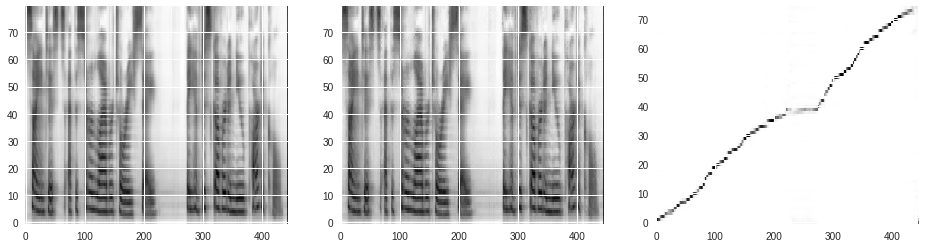

In [0]:
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### save Mel file

In [0]:
mel = mel_outputs_postnet[-1, :, :-1]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
file_name = '/content/mel_tacotron2.pt'
mel = torch.save(mel, file_name)

```


```

----

## Step5. Generate Voice with WaveGlow Model



### check waveglow_old.pt file in COLAB VM
if there exists /content/waveglow_old.pt, skip this process and jump to **5-2**

after run whole step Part1. Voice Synthesis with NVIDIA WaveGlow Model, 
open this jupyter and reconnect it. you could omit the step1 and download WaveGlow files because the COLAB jupyter would be located in same VM. 



In [0]:
ls -alh "/content/waveglow_old.pt"

ls: cannot access '/content/waveglow_old.pt': No such file or directory


### 5-1 copy WaveGlow Snapshot
It takes abaout 15 seconds to download. If you are running jupyter in the same system, you could skip to download file.

In [0]:
%%time
destination="/content/waveglow_old.pt"
file_id="1cjKPHbtAMh_4HTHmuIGNkbOkPBD9qwhj"
download_file_from_google_drive(file_id, destination)

CPU times: user 4.88 s, sys: 5.52 s, total: 10.4 s
Wall time: 22.2 s


In [0]:
ls -alh "./waveglow_old.pt"

-rw-r--r-- 1 root root 2.0G Nov 12 10:45 ./waveglow_old.pt


###  5-2 Configure WaveGlow Model



In [0]:
import os
import sys
import time
import numpy as np
from scipy.io.wavfile import write
import torch
sys.path.insert(0, 'waveglow')

load waveglow weight parameters

In [0]:
%%time
waveglow_path = "waveglow_old.pt"
waveglow = torch.load(waveglow_path)['model']
waveglow.remove_weightnorm()
waveglow.cuda().eval()

CPU times: user 1.14 s, sys: 2.18 s, total: 3.32 s
Wall time: 3.32 s


In [0]:
from mel2samp import files_to_list, MAX_WAV_VALUE
sampling_rate=22050
sigma=0.6

In this example,  Mel  created only one sentence, you have to reduce the dimension to be batch size = 1.

In [0]:
print(mel_outputs_postnet.size())
print(mel_outputs_postnet[-1, :, :].size())

torch.Size([1, 80, 444])
torch.Size([80, 444])


In [0]:
output_dir='/content'
audio_path='/content'
audio_path='/tacotron2+waveglow'

### 5-3 voice synthesis from tacotron Mel.


In [0]:
%%time
import time 

for i  in enumerate(mel_outputs):
    mel = mel_outputs_postnet[-1, :, :]
    mel = torch.autograd.Variable(mel.cuda())
    mel = torch.unsqueeze(mel, 0)
    mel = mel.data
    start= time.perf_counter()
    with torch.no_grad():
        audio = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
    duration= time.perf_counter() - start
    print("inference time {:.2f}s/it".format(duration))
    audio = audio.cpu().numpy()
    audio = audio.astype('int16')
    audio_path = os.path.join(
        output_dir, "{}_synthesis.wav".format(file_name))
    write(audio_path, sampling_rate, audio)
    print(audio_path)


inference time 5.87s/it
/content/mel_tacotron2.pt_synthesis.wav
CPU times: user 3.58 s, sys: 2.29 s, total: 5.87 s
Wall time: 5.87 s


It takes few sec to generate 7 sec audio in Google COLAB which provide Tesla K80.  To implement real-time speech synthesis services, you can take advantage of the latest GPUs, such as Volta (Tesla V100) or Turing (Tesla T4) with TensorRT optimization. I'll provide the perf. result from V100 and T4 soon.

### 5-4 Check Generated Voice

#### audio with  Tacotron2 28K iteration

In [0]:
print(text)
ipd.Audio(audio_path, rate=22050)

Scientists at the CERN laboratory say they have discovered a new particle.


As you have heard, the synthesized voice quality of the parameters which trained 28K iteration was not good quality voice. At the end of the sentence, you could heard the clipping noise.

### eliminate clipping noise

inference time 3.45s/it
/content/mel_tacotron2_clipping.pt_synthesis.wav
CPU times: user 4.38 s, sys: 2.31 s, total: 6.69 s
Wall time: 6.69 s


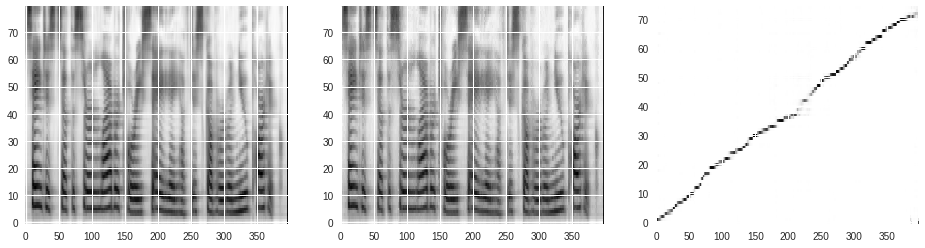

In [0]:
%%time
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))
mel = mel_outputs_postnet[-1, :, :-1]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
file_name = '/content/mel_tacotron2_clipping.pt'
mel = torch.save(mel, file_name)
import time 

for i  in enumerate(mel_outputs):
    mel = mel_outputs_postnet[-1, :, :-1]
    mel = torch.autograd.Variable(mel.cuda())
    mel = torch.unsqueeze(mel, 0)
    mel = mel.data
    start= time.perf_counter()
    with torch.no_grad():
        audio = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
    duration= time.perf_counter() - start
    print("inference time {:.2f}s/it".format(duration))
    audio = audio.cpu().numpy()
    audio = audio.astype('int16')
    audio_path_clipping = os.path.join(
        output_dir, "{}_synthesis.wav".format(file_name))
    write(audio_path_clipping, sampling_rate, audio)
    print(audio_path_clipping)


In [0]:
print(text)
ipd.Audio(audio_path_clipping, rate=22050)

Scientists at the CERN laboratory say they have discovered a new particle.


I eliminate clipping noise with  `mel = mel_outputs_postnet[-1, :, :-1]` instead of `mel_outputs_postnet[-1, :, :]`

#### Audio from NVIDIA reference

download  first sample   [1_taco2_waveglow.wav](http://docs.google.com/uc?export=open&id=1yoQvSK8SmsnmHvQOlgm5w8n9e7-M8YxW) of Tacotron 2 + WaveGlow from ADLR [Waveglow blog](https://nv-adlr.github.io/WaveGlow) to compare the result.

In [0]:
%%time
destination="/content/1_taco2_waveglow.wav"
file_id="1yoQvSK8SmsnmHvQOlgm5w8n9e7-M8YxW"
download_file_from_google_drive(file_id, destination)

CPU times: user 24.3 ms, sys: 5.24 ms, total: 29.6 ms
Wall time: 550 ms


In [0]:
!ls -alh /content/1_taco2_waveglow.wav
taco2_waveglow_ref_audio="/content/1_taco2_waveglow.wav"

-rw-r--r-- 1 root root 176K Nov 12 10:49 /content/1_taco2_waveglow.wav


In [0]:
print(text)
ipd.Audio(taco2_waveglow_ref_audio, rate=22050)

Scientists at the CERN laboratory say they have discovered a new particle.


NVIDIA's reference To get a high quality sound same as NVIDIA's refrence from tacotron2 Mel.

### overfit from trained sentence

  If you use LJSpeech training sentence from [train_filelist](https://raw.githubusercontent.com/NVIDIA/tacotron2/master/filelists/ljs_audio_text_train_filelist.txt) such as **LJ015-0030.wav|"The bank had been conducted on false principles"**  you could generate high quality voice.  If you have enough speech dataset to overfit the audio, generated voice would be very high quality voice.    

In [0]:
%%time
text ="The bank had been conducted on false principles"

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.6 µs


####  synthesis audio from new sentence
Generate voice from "The bank had been conducted on false principles"

inference time 2.43s/it
/content/mel_tacotron2_overfit.pt_synthesis.wav
CPU times: user 3 s, sys: 1.61 s, total: 4.61 s
Wall time: 4.62 s


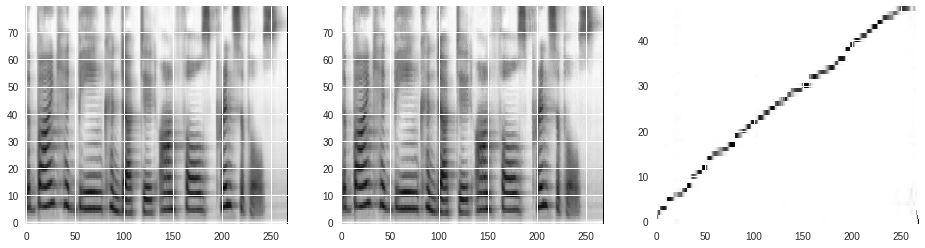

In [0]:
%%time
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))
mel = mel_outputs_postnet[-1, :, :-1]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
file_name = '/content/mel_tacotron2_overfit.pt'
mel = torch.save(mel, file_name)
import time 

for i  in enumerate(mel_outputs):
    mel = mel_outputs_postnet[-1, :, :-1]
    mel = torch.autograd.Variable(mel.cuda())
    mel = torch.unsqueeze(mel, 0)
    mel = mel.data
    start= time.perf_counter()
    with torch.no_grad():
        audio = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
    duration= time.perf_counter() - start
    print("inference time {:.2f}s/it".format(duration))
    audio = audio.cpu().numpy()
    audio = audio.astype('int16')
    audio_path_overfit = os.path.join(
        output_dir, "{}_synthesis.wav".format(file_name))
    write(audio_path_overfit, sampling_rate, audio)
    print(audio_path_overfit)


In [0]:
print(text)
ipd.Audio(audio_path_overfit, rate=22050)

The bank had been conducted on false principles


```

```

### Test more sentences.


Select one sentence from below test sentences.

```
"Scientists at the CERN laboratory say they have discovered a new particle." 
"There's a way to measure the acute emotional intelligence that has never gone out of style." 
"President Trump met with other leaders at the Group of 20 conference." 
"The Senate's bill to repeal and replace the Affordable Care Act is now imperiled." 
"Generative adversarial network or variational auto-encoder.",
"The buses aren't the problem, they actually provide a solution." 
"peter piper picked a peck of pickled peppers how many peppers did peter piper pick." 
"Some have accepted this as a miracle without any physical explanation."
```

```
"Generative adversarial network or variational auto-encoder."
"Basilar membrane and otolaryngology are not auto-correlations."
"He has read the whole thing."
"He reads books."
"Thisss isrealy awhsome."
"This is your personal assistant, Google Home."
"The buses aren't the problem, they actually provide a solution."
"The quick brown fox jumps over the lazy dog."
"Talib Kweli confirmed to AllHipHop that he will be releasing an album in the next year."
"The blue lagoon is a nineteen eighty American romance adventure film."
"Tajima Airport serves Toyooka."
"The forecast for San Mateo tomorrow is sixty one degrees and mostly sunny."
"The Blue Lagoon is a 1980 American romance and adventure film directed by Randal Kleiser."
"That girl did a video about Star Wars lipstick."
"She earned a doctorate in sociology at Columbia University"
"George Washington was the first President of the United States."
"I'm too busy for romance."

```



In [0]:
%%time
text ="The blue lagoon is a nineteen eighty American romance adventure film."

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 12.2 µs


inference time 3.69s/it
/content/mel_tacotron2_others.pt_synthesis.wav
CPU times: user 4.57 s, sys: 2.38 s, total: 6.95 s
Wall time: 6.95 s


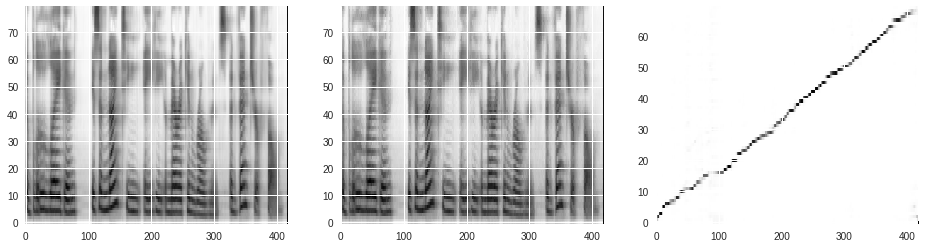

In [0]:
%%time
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))
mel = mel_outputs_postnet[-1, :, :-1]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
file_name = '/content/mel_tacotron2_others.pt'
mel = torch.save(mel, file_name)
import time 

for i  in enumerate(mel_outputs):
    mel = mel_outputs_postnet[-1, :, :-1]
    mel = torch.autograd.Variable(mel.cuda())
    mel = torch.unsqueeze(mel, 0)
    mel = mel.data
    start= time.perf_counter()
    with torch.no_grad():
        audio = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
    duration= time.perf_counter() - start
    print("inference time {:.2f}s/it".format(duration))
    audio = audio.cpu().numpy()
    audio = audio.astype('int16')
    audio_path_others = os.path.join(
        output_dir, "{}_synthesis.wav".format(file_name))
    write(audio_path_others, sampling_rate, audio)
    print(audio_path_others)


In [0]:
print(text)
ipd.Audio(audio_path_others, rate=22050)

The blue lagoon is a nineteen eighty American romance adventure film.


```


```
---

## Summary

I demonstrate how to integrate both of Tacotron2 + Waveglow Model to synthesize voice from text.  In the first step, generate Mel Spectrogram from text with Tacotron 2 Model. after that, generate voice from generated Mel with WaveGlow Model. 

## Reference
- paper  https://arxiv.org/abs/1811.00002

- blog https://nv-adlr.github.io/WaveGlow 

- github https://github.com/NVIDIA/tacotron2

- github https://github.com/NVIDIA/waveglow

```

```

```

```